# 신규 고객의 유입을 늘리면 매출 향상에 영향을 줄 것이다.

## 데이터 확인

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import datetime as dt

In [2]:
customer_df = pd.read_csv('C:/Users/hakju/OneDrive/바탕 화면/study/FIRST_PROJECT/archive/Customers_Data.csv')
discount_coupon_df = pd.read_csv('C:/Users/hakju/OneDrive/바탕 화면/study/FIRST_PROJECT/archive/Discount_Coupon.csv')
marketing_spend_df = pd.read_csv('C:/Users/hakju/OneDrive/바탕 화면/study/FIRST_PROJECT/archive/Marketing_Spend.csv')
online_sales_df = pd.read_csv('C:/Users/hakju/OneDrive/바탕 화면/study/FIRST_PROJECT/archive/Online_Sales.csv')
tax_amount_df = pd.read_csv('C:/Users/hakju/OneDrive/바탕 화면/study/FIRST_PROJECT/archive/Tax_Amount.csv')

In [3]:
customer_df.head()

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [4]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB


In [5]:
online_sales_df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


In [6]:
online_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  object 
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB


## 고객 등급 분류
RFM 분석 (참고 : https://datarian.io/blog/what-is-rfm)
- Recency : 얼마나 최근에 구매했는가 (최근 2개월 이내에 구매 이력이 있는가)
    - 평균 재구매 기간 : 54일 (약 2개월)
- Frequency : 얼마나 자주 구매했는가 (18건 이상)
    - 평균 구매건수 : 약 18건
- Monetary : 얼마나 많은 금액을 지출했는가 (1832 이상)
    - 주문 금액 중앙값 (1832)

고객의 등급을 어떻게 나눌 것인가?
- 3개 모두 만족 -> 충성고객
- 최근 구매이력이 있는 고객 -> 일반 고객
- 최근 구매이력이 없고, 나머지 1개 or 2개(떠나간 vip) 만족 -> 잠재 이탈 고객
- 0개 만족 -> 이탈 고객

신규 고객은 별도로 지정 (이놈이 문제)
- 최근 3개월 이내에 회원 가입 및 구매 이력이 있는 고객 (-> 49명)
<!-- - 최초 구매일자가 3개월 이내인 고객 -->

In [7]:
# 데이트 포멧 변경
online_sales_df['Transaction_Date'] = pd.to_datetime(online_sales_df['Transaction_Date'], format='%m/%d/%Y')
online_sales_df['Transaction_Date'].value_counts().sort_index()

Transaction_Date
2019-01-01     89
2019-01-02    115
2019-01-03    207
2019-01-04    169
2019-01-05    189
             ... 
2019-12-27    103
2019-12-28     80
2019-12-29     89
2019-12-30     61
2019-12-31     67
Name: count, Length: 365, dtype: int64

### 평균 재구매 기간
 - 약 54일

In [8]:
repurchase = online_sales_df.groupby(['CustomerID'])['Transaction_Date'].apply(list).reset_index()

repurchase

,CustomerID,Transaction_Date
0,12346,"[2019-09-15 00:00:00, 2019-09-15 00:00:00]"
1,12347,"[2019-03-24 00:00:00, 2019-03-24 00:00:00, 201..."
2,12348,"[2019-06-22 00:00:00, 2019-06-22 00:00:00, 201..."
3,12350,"[2019-12-14 00:00:00, 2019-12-14 00:00:00, 201..."
4,12356,"[2019-09-15 00:00:00, 2019-09-15 00:00:00, 201..."
...,...,...
1463,18259,"[2019-04-05 00:00:00, 2019-04-05 00:00:00, 201..."
1464,18260,"[2019-06-22 00:00:00, 2019-06-22 00:00:00, 201..."
1465,18269,"[2019-04-05 00:00:00, 2019-04-05 00:00:00, 201..."
1466,18277,[2019-10-23 00:00:00]


In [9]:
# 중복 날짜 제거
for i, date_list in enumerate(repurchase['Transaction_Date']) :
    date_list_deduplication = []
    
    for date_time in date_list :
        if date_time not in date_list_deduplication :
            date_list_deduplication.append(date_time)
    
    repurchase.at[i, 'Transaction_Date'] = date_list_deduplication
        
repurchase.head()

,CustomerID,Transaction_Date
0,12346,[2019-09-15 00:00:00]
1,12347,"[2019-03-24 00:00:00, 2019-11-01 00:00:00, 201..."
2,12348,"[2019-06-22 00:00:00, 2019-10-19 00:00:00]"
3,12350,[2019-12-14 00:00:00]
4,12356,[2019-09-15 00:00:00]


In [10]:
repurchase.loc[1, 'Transaction_Date']

[Timestamp('2019-03-24 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-11-02 00:00:00')]

In [11]:
diff_list = []

for date in repurchase['Transaction_Date'] :
    # print(len(date))
    
    if len(date) >= 2 :
        for i in range(len(date) - 1) :
            diff_list.append((date[i+1]-date[i]).days)

repurchase_mean = np.mean(diff_list)
repurchase_median = np.median(diff_list)

print(repurchase_mean, repurchase_median)

54.29827586206896 32.0


<Axes: ylabel='Count'>

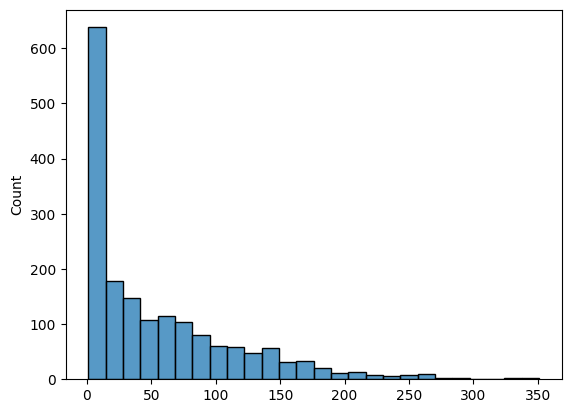

In [12]:
sns.histplot(diff_list)

<Axes: >

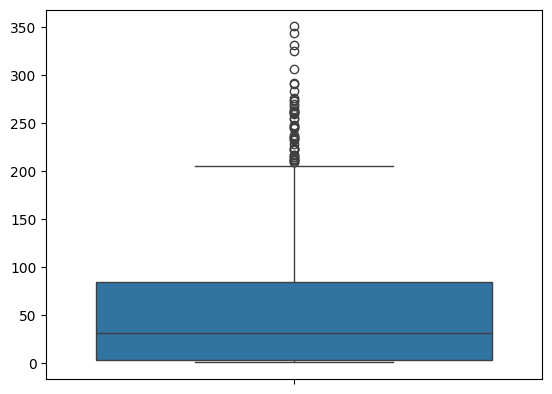

In [13]:
sns.boxplot(diff_list)

### 평균 주문건수
- transantion id 기준
- 약 18건

In [14]:
frequency = online_sales_df.groupby(['CustomerID'])[['Transaction_ID']].nunique()

frequency

,Transaction_ID
CustomerID,
12346,1
12347,31
12348,8
12350,11
12356,13
...,...
18259,3
18260,19
18269,2


In [15]:
frequency_mean = np.mean(frequency['Transaction_ID'])

frequency_mean

18.141008174386922

### 평균 지출액 계산
- 매출액 = 평균가 * (1-GST) * 판매량 * (1-할인률) + 배송비
- 지출액 = 평균가 * 구매량 * (1-할인률) + 배송비

In [16]:
discount_coupon_df['Month'].value_counts()

Month
Jan    17
Feb    17
Mar    17
Apr    17
May    17
Jun    17
Jul    17
Aug    17
Sep    17
Oct    17
Nov    17
Dec    17
Name: count, dtype: int64

In [17]:
discount_coupon_numeric_df = discount_coupon_df.copy()  
discount_coupon_numeric_df.head()

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [18]:
def get_numeric(month) :
    if month == 'Jan' :
        return 1    
    elif month == 'Feb' :
        return 2
    elif month == 'Mar' :
        return 3
    elif month == 'Apr' :
        return 4
    elif month == 'May' :
        return 5
    elif month == 'Jun' :
        return 6
    elif month == 'Jul' :
        return 7
    elif month == 'Aug' :
        return 8
    elif month == 'Sep' :
        return 9
    elif month == 'Oct' :
        return 10
    elif month == 'Nov' :
        return 11
    elif month == 'Dec' :
        return 12    

In [19]:
discount_coupon_numeric_df['Month_Numeric'] = discount_coupon_df['Month'].map(get_numeric)
discount_coupon_numeric_df.head()

,Month,Product_Category,Coupon_Code,Discount_pct,Month_Numeric
0,Jan,Apparel,SALE10,10,1
1,Feb,Apparel,SALE20,20,2
2,Mar,Apparel,SALE30,30,3
3,Jan,Nest-USA,ELEC10,10,1
4,Feb,Nest-USA,ELEC20,20,2


In [20]:
def get_month_product(month, product) :
    month = str(month)
    month_product = month + '_' + product
    return month_product

In [21]:
discount_coupon_numeric_df['Month_Product'] = discount_coupon_numeric_df[['Month_Numeric', 'Product_Category']].apply(lambda x: get_month_product(*x), axis=1)
discount_coupon_numeric_df.head()

,Month,Product_Category,Coupon_Code,Discount_pct,Month_Numeric,Month_Product
0,Jan,Apparel,SALE10,10,1,1_Apparel
1,Feb,Apparel,SALE20,20,2,2_Apparel
2,Mar,Apparel,SALE30,30,3,3_Apparel
3,Jan,Nest-USA,ELEC10,10,1,1_Nest-USA
4,Feb,Nest-USA,ELEC20,20,2,2_Nest-USA


In [22]:
online_sales_df['Month_Numeric'] = online_sales_df['Transaction_Date'].dt.month
online_sales_df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month_Numeric
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,1
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,1
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,1


In [23]:
online_sales_df['Month_Product'] = online_sales_df[['Month_Numeric', 'Product_Category']].apply(lambda x : get_month_product(*x), axis=1)
online_sales_df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month_Numeric,Month_Product
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,1_Nest-USA
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,1_Nest-USA
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,1,1_Office
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,1,1_Apparel
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,1,1_Bags


In [24]:
Monetary_df = pd.merge(left=online_sales_df, right=discount_coupon_numeric_df, how='left', on='Month_Product')

Monetary_df = Monetary_df[['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_Category_x', 'Quantity', 'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'Coupon_Code', 'Discount_pct']]
Monetary_df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_Category_x,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct
0,17850,16679,2019-01-01,Nest-USA,1,153.71,6.5,Used,ELEC10,10.0
1,17850,16680,2019-01-01,Nest-USA,1,153.71,6.5,Used,ELEC10,10.0
2,17850,16681,2019-01-01,Office,1,2.05,6.5,Used,OFF10,10.0
3,17850,16682,2019-01-01,Apparel,5,17.53,6.5,Not Used,SALE10,10.0
4,17850,16682,2019-01-01,Bags,1,16.50,6.5,Used,AIO10,10.0


In [29]:
Monetary_df.to_csv('Monetary.csv', index=False)

In [ ]:
# 지출액 = 평균가 * 구매량 * (1-할인률) + 배송비
def get_payment(Avg_Price, Quantity, Discount_pct, Delivery_Charges, Coupon_Status) :
    if Coupon_Status == 'Used' :
        payment = Avg_Price * Quantity * (1-(Discount_pct/100)) + Delivery_Charges
        return payment
    else :
        payment = Avg_Price * Quantity + Delivery_Charges
        return payment

In [ ]:
Monetary_df['Payment'] = Monetary_df[['Avg_Price', 'Quantity', 'Discount_pct', 'Delivery_Charges', 'Coupon_Status']].apply(lambda x : get_payment(*x), axis=1)

Monetary_df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_Category_x,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,Payment
0,17850,16679,2019-01-01,Nest-USA,1,153.71,6.5,Used,ELEC10,10.0,144.839
1,17850,16680,2019-01-01,Nest-USA,1,153.71,6.5,Used,ELEC10,10.0,144.839
2,17850,16681,2019-01-01,Office,1,2.05,6.5,Used,OFF10,10.0,8.345
3,17850,16682,2019-01-01,Apparel,5,17.53,6.5,Not Used,SALE10,10.0,94.150
4,17850,16682,2019-01-01,Bags,1,16.50,6.5,Used,AIO10,10.0,21.350


In [ ]:
Monetary_df_groupby = Monetary_df.groupby('CustomerID')[['Payment']].sum()

Monetary_df_groupby.describe()

,Payment
count,1468.000000
mean,3341.847229
std,5280.320938
min,6.900000
25%,707.057750
50%,1832.670500
75%,4093.549000
max,77886.782000


<Axes: xlabel='Payment'>

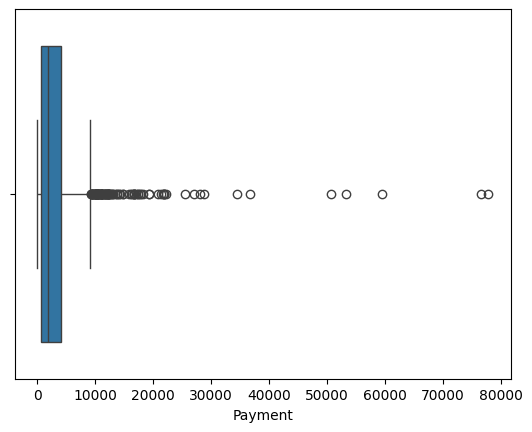

In [ ]:
sns.boxplot(Monetary_df_groupby, x='Payment')

In [ ]:
payment_median = Monetary_df_groupby['Payment'].quantile(0.5)

payment_median

1832.6705000000002

### 신규 고객 파악

In [ ]:
customer_level_df = customer_df.copy()
customer_level_df.head()

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [ ]:
# 신규고객 분류
# 최근 3개월 이내에 가입했고, 구매 이력이 있는 고객

cond = customer_level_df['Tenure_Months'] <= 3

customer_level_df[cond].head()

,CustomerID,Gender,Location,Tenure_Months
70,12472,F,New Jersey,2
83,16539,M,California,2
135,12915,F,Washington DC,3
140,15827,F,Chicago,3
283,15716,F,Chicago,2


In [ ]:
new_customer = pd.merge(left=customer_level_df[cond], right=online_sales_df, how='left', on='CustomerID')

new_customer.head()

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month_Numeric,Month_Product
0,12472,F,New Jersey,2,17663,2019-01-11,GGOEGOAB016099,Leather and Metal Ballpoint Pen,Office,2,18.56,6.5,Clicked,1,1_Office
1,12472,F,New Jersey,2,17663,2019-01-11,GGOEGOAB021499,Metal Texture Roller Pen,Office,2,29.91,6.5,Clicked,1,1_Office
2,12472,F,New Jersey,2,17663,2019-01-11,GGOEGOAB022499,Satin Black Ballpoint Pen,Office,1,41.26,6.5,Not Used,1,1_Office
3,12472,F,New Jersey,2,17664,2019-01-11,GGOEGDHC018299,Google 22 oz Water Bottle,Drinkware,1,3.08,6.5,Clicked,1,1_Drinkware
4,12472,F,New Jersey,2,17664,2019-01-11,GGOEWAAJ082815,Waze Men's Short Sleeve Tee,Waze,1,19.59,6.5,Used,1,1_Waze


In [ ]:
new_customer_groupby = new_customer.groupby('CustomerID')[['Quantity']].sum()
cond2 = (new_customer_groupby['Quantity'] == 0)

cond2.sum()

0

### 고객 등급 분류
 - 충성, 일반, 신규, 잠재이탈, 이탈

최근 구매일 2개월 이내인 고객 (11월 1일 이후 구매 이력이 있는 고객)

In [ ]:
purchase = online_sales_df['Transaction_Date'] >= '2019-11-01'
purchase_customer_df = online_sales_df[purchase].groupby('CustomerID')[['Transaction_ID']].nunique()

purchase_customer_df.index

Index([12347, 12350, 12373, 12377, 12410, 12414, 12431, 12437, 12464, 12468,
       ...
       18075, 18095, 18125, 18145, 18178, 18198, 18202, 18239, 18245, 18250],
      dtype='int64', name='CustomerID', length=396)

In [ ]:
customer_level_df['recency'] = 'past'

In [ ]:
for i, id in enumerate(customer_level_df['CustomerID']):
    if id in purchase_customer_df.index :
        customer_level_df.loc[i, 'recency'] = 'recent'

In [ ]:
customer_level_df.head()

,CustomerID,Gender,Location,Tenure_Months,recency
0,17850,M,Chicago,12,past
1,13047,M,California,43,recent
2,12583,M,Chicago,33,past
3,13748,F,California,30,past
4,15100,M,California,49,past


평균 주문건수 (18건) 이상인 고객 분류

In [ ]:
customer_level_df['frequency'] = 'low'

In [ ]:
cond3 = frequency['Transaction_ID'] >= 18

frequency[cond3].index

Index([12347, 12370, 12377, 12383, 12415, 12431, 12433, 12451, 12471, 12472,
       ...
       18125, 18145, 18156, 18168, 18212, 18223, 18239, 18245, 18260, 18283],
      dtype='int64', name='CustomerID', length=500)

In [ ]:
for i, id in enumerate(customer_level_df['CustomerID']):
    if id in frequency[cond3].index :
        customer_level_df.loc[i, 'frequency'] = 'high'

In [ ]:
customer_level_df['frequency'].value_counts()

frequency
low     968
high    500
Name: count, dtype: int64

평균 지출액이 기준(1832) 이상인 고객 분류

In [ ]:
customer_level_df['monetary'] = 'low'

In [ ]:
df = Monetary_df.groupby('CustomerID')[['Payment']].sum()
cond4 = df['Payment'] >= 1832

df[cond4].index

Index([12347, 12356, 12370, 12377, 12383, 12393, 12410, 12413, 12415, 12417,
       ...
       18198, 18202, 18212, 18223, 18229, 18239, 18245, 18250, 18260, 18283],
      dtype='int64', name='CustomerID', length=734)

In [ ]:
for i, id in enumerate(customer_level_df['CustomerID']):
    if id in df[cond4].index :
        customer_level_df.loc[i, 'monetary'] = 'high'

In [ ]:
customer_level_df['monetary'].value_counts()

monetary
high    734
low     734
Name: count, dtype: int64

고객 최종 등급(level) 분류
-loyal_customer
-regular_customer
-new_customer
-potential_churn_customer
-churn_customer

In [ ]:
customer_level_df.head()

,CustomerID,Gender,Location,Tenure_Months,recency,frequency,monetary
0,17850,M,Chicago,12,past,high,high
1,13047,M,California,43,recent,high,high
2,12583,M,Chicago,33,past,low,high
3,13748,F,California,30,past,low,low
4,15100,M,California,49,past,low,low


In [ ]:
customer_level_df['Level'] = ''

In [ ]:
def get_customer_level(recency, frequency, monetary) :
    if (recency == 'recent') and (frequency == 'high') and (monetary == 'high') :
        return 'loyal_customer'
    elif recency == 'recent' :
        return 'regular_customer'
    elif (recency == 'past') and (frequency == 'low') and (monetary == 'low') :
        return 'churn_customer'
    else :
        return 'potential_churn_customer'

In [ ]:
customer_level_df['Level'] = customer_level_df[['recency', 'frequency','monetary']].apply(lambda x : get_customer_level(*x), axis=1)

In [ ]:
# 신규 고객
customer_level_df.loc[cond, 'Level'] = 'new_customer'

In [ ]:
customer_level_df['Level'].value_counts()

Level
churn_customer              585
potential_churn_customer    446
regular_customer            196
loyal_customer              192
new_customer                 49
Name: count, dtype: int64

In [ ]:
customer_level_df['Level'].value_counts(normalize=True)

Level
churn_customer              0.398501
potential_churn_customer    0.303815
regular_customer            0.133515
loyal_customer              0.130790
new_customer                0.033379
Name: proportion, dtype: float64

C:\Users\hakju\AppData\Local\Temp\ipykernel_27416\388875367.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_xticklabels(graph.get_xticklabels(), rotation=45)


[Text(0, 0, 'potential_churn_customer'),
 Text(1, 0, 'loyal_customer'),
 Text(2, 0, 'churn_customer'),
 Text(3, 0, 'regular_customer'),
 Text(4, 0, 'new_customer')]

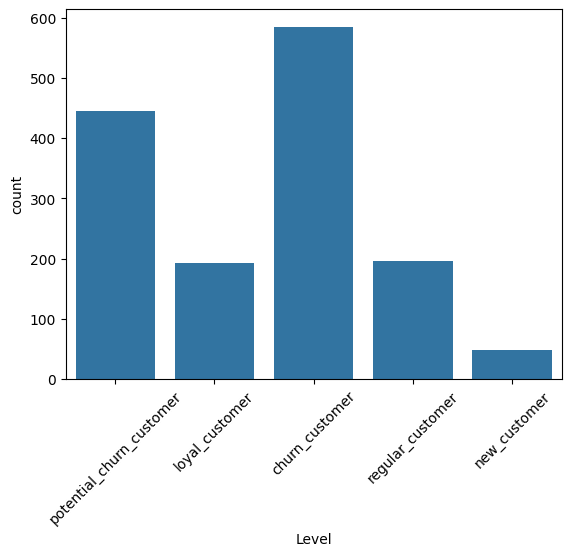

In [ ]:
graph = sns.countplot(data=customer_level_df, x='Level')
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)

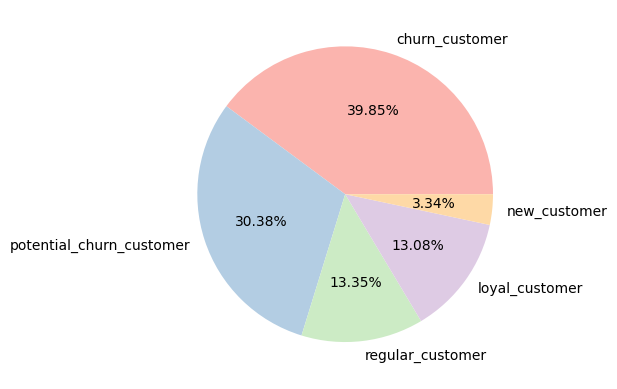

In [ ]:
level_cnt = customer_level_df['Level'].value_counts()
colors = plt.cm.Pastel1(range(len(level_cnt)))

plt.pie(level_cnt, labels=level_cnt.index, autopct='%1.2f%%', colors=colors)
plt.show()

## 각 고객 등급 별 평균 지출액 및 주문 횟수

### 평균 지출액

In [ ]:
Monetary_df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_Category_x,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,Payment
0,17850,16679,2019-01-01,Nest-USA,1,153.71,6.5,Used,ELEC10,10.0,144.839
1,17850,16680,2019-01-01,Nest-USA,1,153.71,6.5,Used,ELEC10,10.0,144.839
2,17850,16681,2019-01-01,Office,1,2.05,6.5,Used,OFF10,10.0,8.345
3,17850,16682,2019-01-01,Apparel,5,17.53,6.5,Not Used,SALE10,10.0,94.150
4,17850,16682,2019-01-01,Bags,1,16.50,6.5,Used,AIO10,10.0,21.350


In [ ]:
level_monetary_df = pd.merge(left=Monetary_df, right=customer_level_df, how='left', on='CustomerID')
level_monetary_df

,CustomerID,Transaction_ID,Transaction_Date,Product_Category_x,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,Payment,Gender,Location,Tenure_Months,recency,frequency,monetary,Level
0,17850,16679,2019-01-01,Nest-USA,1,153.71,6.50,Used,ELEC10,10.0,144.839,M,Chicago,12,past,high,high,potential_churn_customer
1,17850,16680,2019-01-01,Nest-USA,1,153.71,6.50,Used,ELEC10,10.0,144.839,M,Chicago,12,past,high,high,potential_churn_customer
2,17850,16681,2019-01-01,Office,1,2.05,6.50,Used,OFF10,10.0,8.345,M,Chicago,12,past,high,high,potential_churn_customer
3,17850,16682,2019-01-01,Apparel,5,17.53,6.50,Not Used,SALE10,10.0,94.150,M,Chicago,12,past,high,high,potential_churn_customer
4,17850,16682,2019-01-01,Bags,1,16.50,6.50,Used,AIO10,10.0,21.350,M,Chicago,12,past,high,high,potential_churn_customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,Nest-USA,1,121.30,6.50,Clicked,ELEC30,30.0,127.800,F,New York,45,recent,low,low,regular_customer
52920,14410,48494,2019-12-31,Apparel,1,48.92,6.50,Used,SALE30,30.0,40.744,F,New York,45,recent,low,low,regular_customer
52921,14410,48495,2019-12-31,Nest-USA,1,151.88,6.50,Used,ELEC30,30.0,112.816,F,New York,45,recent,low,low,regular_customer
52922,14600,48496,2019-12-31,Nest-USA,5,80.52,6.50,Clicked,ELEC30,30.0,409.100,F,California,7,recent,low,low,regular_customer


In [ ]:
level_monetary_df_groupby = level_monetary_df.groupby('Level')[['Payment']].mean()
level_monetary_df_groupby = level_monetary_df_groupby.sort_values(by=['Payment'], ascending=False)
level_monetary_df_groupby

,Payment
Level,
loyal_customer,103.353547
regular_customer,100.181084
potential_churn_customer,91.754160
new_customer,86.421601
churn_customer,67.825469


<Axes: xlabel='Payment', ylabel='Level'>

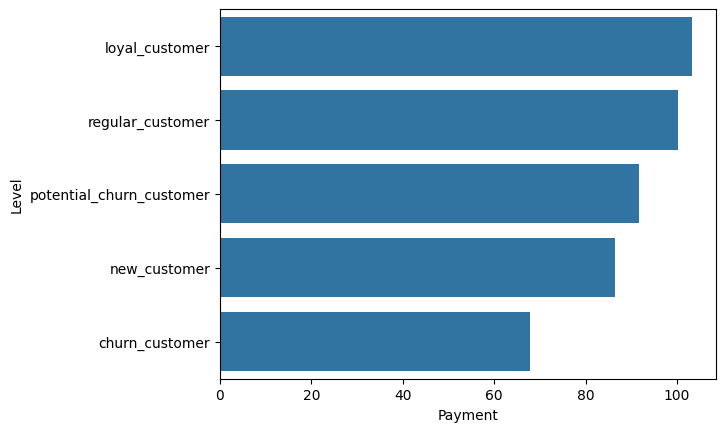

In [ ]:
sns.barplot(level_monetary_df_groupby, x='Payment', y='Level')

In [ ]:
frequency = frequency.reset_index()

frequency

,CustomerID,Transaction_ID
0,12346,1
1,12347,31
2,12348,8
3,12350,11
4,12356,13
...,...,...
1463,18259,3
1464,18260,19
1465,18269,2
1466,18277,1


### 평균 주문 횟수

In [ ]:
level_frequency = pd.merge(left=frequency, right=customer_level_df, how='left', on='CustomerID')

level_frequency

,CustomerID,Transaction_ID,Gender,Location,Tenure_Months,recency,frequency,monetary,Level
0,12346,1,F,New York,31,past,low,low,churn_customer
1,12347,31,M,New York,20,recent,high,high,loyal_customer
2,12348,8,M,California,39,past,low,low,churn_customer
3,12350,11,M,California,25,recent,low,low,regular_customer
4,12356,13,F,Chicago,31,past,low,high,potential_churn_customer
...,...,...,...,...,...,...,...,...,...
1463,18259,3,F,California,5,past,low,low,churn_customer
1464,18260,19,M,New York,43,past,high,high,potential_churn_customer
1465,18269,2,M,Chicago,25,past,low,low,churn_customer
1466,18277,1,F,Chicago,47,past,low,low,churn_customer


In [ ]:
level_frequency_groupby = level_frequency.groupby('Level')[['Transaction_ID']].mean()
level_frequency_groupby = level_frequency_groupby.sort_values(by=['Transaction_ID'], ascending=False)

level_frequency_groupby

,Transaction_ID
Level,
loyal_customer,46.317708
potential_churn_customer,27.390135
new_customer,13.428571
regular_customer,8.831633
churn_customer,5.355556


<Axes: xlabel='Transaction_ID', ylabel='Level'>

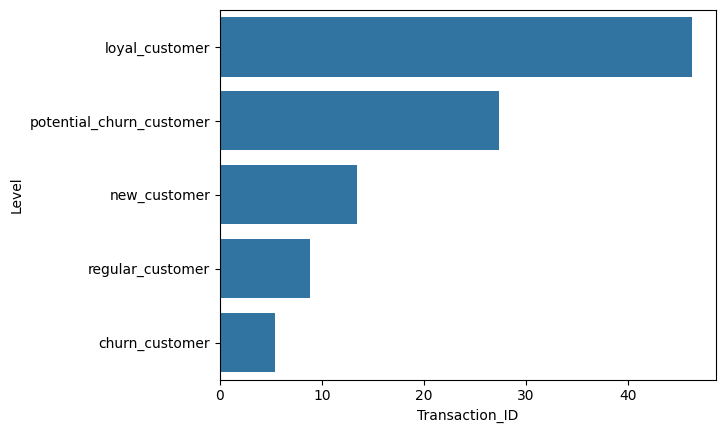

In [ ]:
sns.barplot(level_frequency_groupby, x='Transaction_ID', y='Level')

### 평균 지출액 및 주문 횟수 그래프

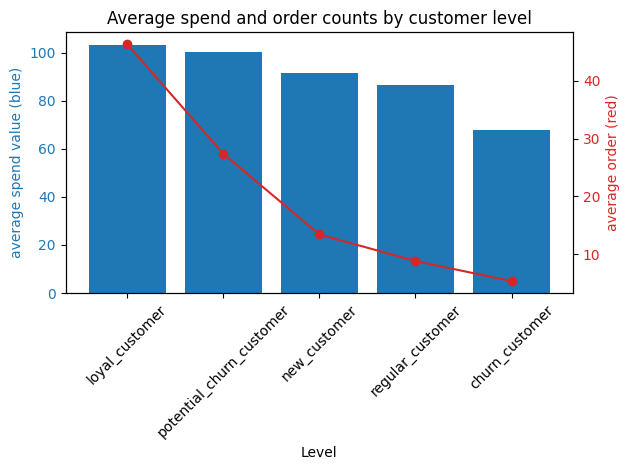

In [ ]:
# left side
fig, ax1 = plt.subplots()
color_1 = 'tab:blue'
ax1.set_title('Average spend and order counts by customer level', fontsize=12)
ax1.set_xlabel('Level')
ax1.set_ylabel('average spend value (blue)', fontsize=10, color=color_1)
ax1.bar(level_monetary_df_groupby.index, level_monetary_df_groupby['Payment'], color=color_1)
plt.xticks(rotation=45)
ax1.tick_params(axis='y', labelcolor=color_1)

# right side
ax2 = ax1.twinx()
color_2 = 'tab:red'
ax2.set_ylabel('average order (red)', fontsize=10, color=color_2)
ax2.plot(level_frequency_groupby.index, level_frequency_groupby['Transaction_ID'], marker='o', color=color_2)
ax2.tick_params(axis='y', labelcolor=color_2)

fig.tight_layout()
plt.show()

### 결론
- 2019년 기준 Practice의 신규 고객은 3.34%로 비중이 적다고 볼 수 있다.
- 하지만 신규 고객의 평균 지출액은 약 86.4$로 높은 수준을 보이고 있다.
- 또한, 주문수 대비 지출액이 많은 것으로 나타났다.
- 따라서 신규 고객을 겨냥한 마케팅을 진행한다면 Practice의 매출에 좋은 영향을 미칠 수 있을 것으로 파악된다.